In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
import time
from sklearn.externals.six import StringIO 
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
import graphviz
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold

In [6]:
#import data
towny=pd.read_csv('towny_df',index_col='town')
targets=pd.read_csv('target_df',index_col='town')
norm_towny=pd.read_csv('normalized_towns',index_col='town')
norm_buildings=pd.read_csv('norm_buildings_df',index_col='town')
income_binary=pd.read_csv('incomes binary split',index_col='town')

In [7]:
income_binary.shape

(1065, 3)

count    1065.000000
mean       20.534359
std       177.517823
min         0.000000
25%         4.096934
50%         7.847670
75%        14.380868
max      5558.735308
Name: com_elec_ghg, dtype: float64


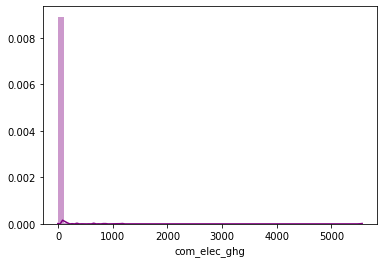

In [8]:
category='com_elec_ghg'
df=norm_buildings
print(df[category].describe())
sns.distplot(df[category].dropna(),color='purple')

In [11]:
norm_towny.describe()

,biz,com_elec_ghg,com_gas_1kdol,com_gas_ghg,com_gas_mcf,houses,ind,ind_elec_ghg,ind_gas_1kdol,ind_gas_ghg,ind_gas_mcf,res_elec_ghg,res_gas_1kdol,res_gas_ghg,res_gas_mcf,age,edu,income,poverty
count,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000
mean,0.018976,5643.520018,0.071638,1173.822487,9.778376,0.381064,0.005342,4956.588811,0.098017,2311.038390,19.251806,5792.460813,0.163917,2112.644679,17.599111,0.002113,0.004762,3.391934,0.000650
std,0.006806,3747.072921,0.058250,918.437217,7.650923,0.040641,0.005118,10321.803795,0.184410,4498.900856,37.477508,1991.317247,0.090528,1344.066371,11.196570,0.004773,0.010425,7.525635,0.001237
min,0.000000,198.075750,0.000000,0.000000,0.000000,0.240946,0.000504,12.490506,0.000168,3.135775,0.026046,1621.858390,0.000000,0.000000,0.000000,0.000004,0.000010,0.009428,0.000002
25%,0.014517,3433.885031,0.035235,560.899055,4.672512,0.356635,0.003204,681.570533,0.015570,329.373451,2.743804,4042.051563,0.095939,1042.619172,8.685405,0.000594,0.001428,0.902630,0.000156
50%,0.018049,4852.122595,0.061118,1016.206681,8.465378,0.383378,0.004277,1967.021137,0.045452,991.381984,8.258585,5853.324595,0.169282,2060.465911,17.164437,0.001197,0.002764,1.816552,0.000301
75%,0.021970,6882.014665,0.093660,1556.000072,12.962063,0.408225,0.006000,5184.139142,0.100538,2313.952991,19.276085,7237.224785,0.222526,3042.815493,25.347728,0.001922,0.004419,3.139356,0.000675
max,0.067554,64618.249357,0.638175,9407.883676,78.371465,0.546727,0.110549,157866.084734,2.438585,60860.387337,506.989561,11132.902017,0.766126,8832.517096,73.578136,0.082688,0.194305,121.128242,0.017152


In [12]:
income_binary.columns

Index(['median', 'mean', 'income'], dtype='object')

In [177]:
X=norm_towny.drop(['age','edu','income','poverty'],axis=1,inplace=False)
y=income_binary['median']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,train_size=.7)
smote = SMOTE(ratio='minority')

X_sm_train, y_sm_train = smote.fit_resample(X_train, y_train)
# X_sm_test, y_sm_test = smote.fit_resample(X_test, y_test)

In [178]:
dt_clf = DecisionTreeClassifier(criterion= 'entropy',
 max_depth= 5,
 min_samples_leaf= 6,
 min_samples_split= 8)

dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")
# {'criterion': 'entropy',
#  'max_depth': 5,
#  'min_samples_leaf': 1,
#  'min_samples_split': 10}

Mean Cross Validation Score: 64.97%


In [179]:
X_sm_train.shape

(750, 15)

In [180]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6,20],
    'min_samples_split': [2, 5, 10,20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6,20]
}

In [181]:
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='entropy', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=6,
                                              min_samples_split=8,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6, 20],
            

In [182]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Testing Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 78.86%
Mean Testing Score: 61.88%
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 10}

In [22]:
##Spot-Checking Algorithms
models = []
# models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('XGB', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
#testing models
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=42)
    cv_results = cross_val_score(model, X_sm_train, y_sm_train, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.692000 (0.039866)
KNN: 0.650667 (0.031721)
CART: 0.638667 (0.033572)
SVM: 0.457333 (0.022940)
XGB: 0.680000 (0.031833)
RF: 0.668000 (0.029933)


Confusion matrix, without normalization
[[106  57]
 [ 46 111]]
Normalized confusion matrix
[[0.65 0.35]
 [0.29 0.71]]


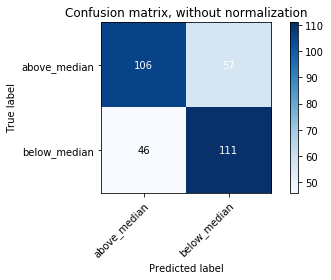

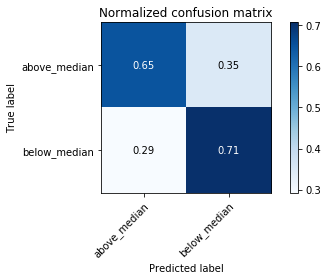

In [183]:

dt_clf.fit(X_train, y_train)
y_pred_class=dt_clf.predict(X_test)
y_pred=dt_clf.predict(X_test)
cf = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names=['above_median','below_median']
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_sm_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_sm_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

Those 1% towns do not necessarily mean uber rich, just wealthy areas with low income diversity

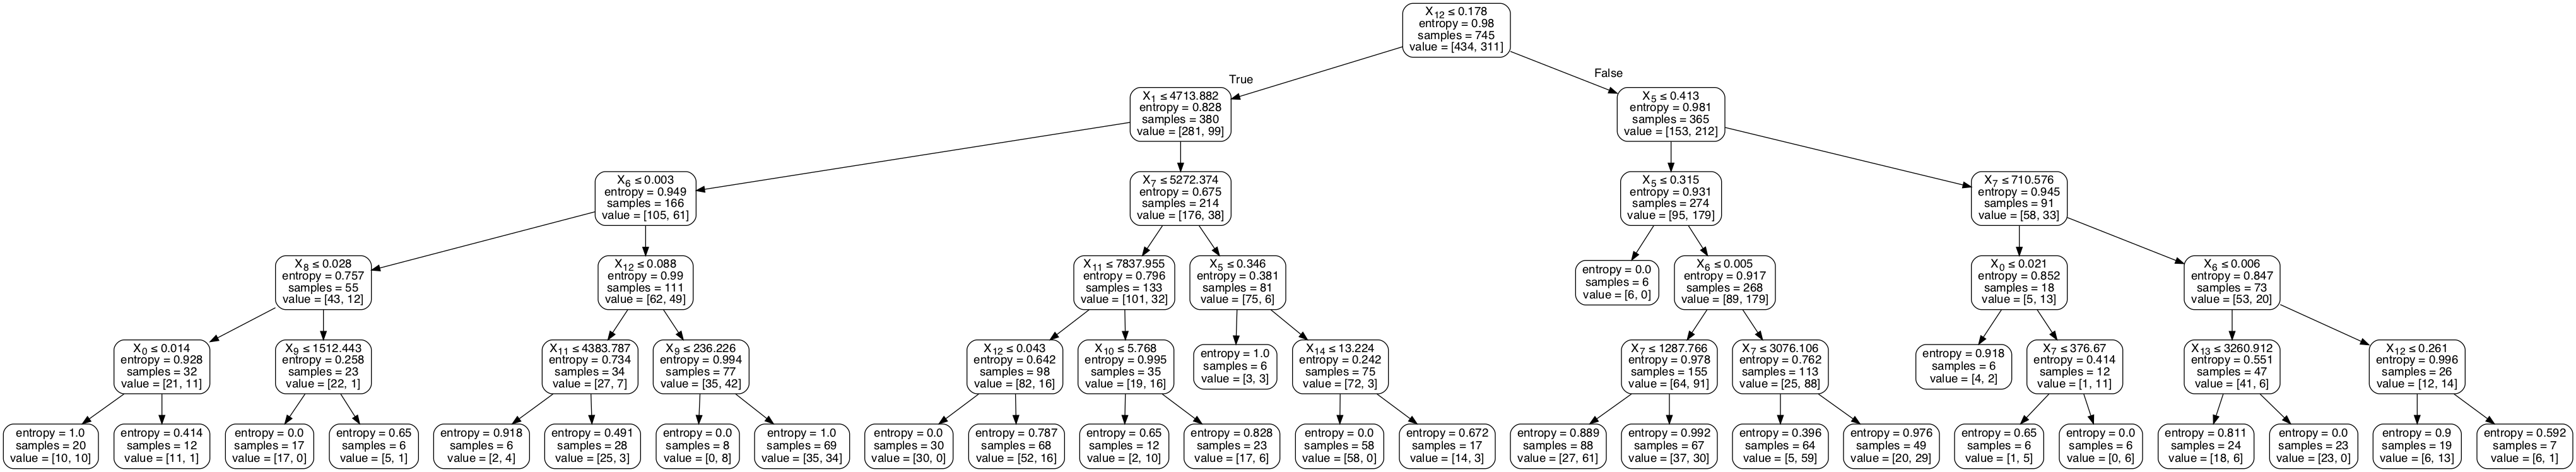

In [97]:

dt_clf.fit(X_train, y_train)
dot_data = StringIO()
export_graphviz(dt_clf, out_file=dot_data,  
                rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [151]:
# pred=X_test.copy()
# pred['by_mean']=y_pred_mean
# pred['by_median']=y_pred
pred['by_median_t']=income_binary['median']
pred['by_mean_t']=income_binary['mean']

In [70]:
# med_pred=med_pred.set_index(med_pred[0],drop=True)

In [118]:
pred.groupby('by_median')[['houses','biz','ind']].describe().transpose()

by_median              1           2
houses count  152.000000  168.000000
       mean     0.382494    0.374651
       std      0.045148    0.034340
       min      0.240946    0.277024
       25%      0.361686    0.351104
       50%      0.390445    0.379091
       75%      0.418331    0.399575
       max      0.455258    0.493756
biz    count  152.000000  168.000000
       mean     0.019645    0.017243
       std      0.006878    0.005334
       min      0.004540    0.000000
       25%      0.015303    0.013441
       50%      0.019289    0.016655
       75%      0.023365    0.019714
       max      0.048843    0.042421
ind    count  152.000000  168.000000
       mean     0.005074    0.005416
       std      0.003355    0.008741
       min      0.000825    0.001467
       25%      0.003381    0.003154
       50%      0.004281    0.004055
       75%      0.005560    0.005196
       max      0.029563    0.110549

In [117]:
pred.groupby('by_mean')[['houses','biz','ind']].describe().transpose()

by_mean                1          2
houses count  226.000000  94.000000
       mean     0.378535   0.377995
       std      0.042905   0.032034
       min      0.240946   0.315395
       25%      0.354052   0.357929
       50%      0.384564   0.380851
       75%      0.412645   0.398835
       max      0.464139   0.493756
biz    count  226.000000  94.000000
       mean     0.018361   0.018438
       std      0.006448   0.005680
       min      0.004540   0.000000
       25%      0.014027   0.014821
       50%      0.017453   0.017859
       75%      0.021712   0.021689
       max      0.048843   0.042421
ind    count  226.000000  94.000000
       mean     0.005172   0.005448
       std      0.007653   0.003719
       min      0.000825   0.001542
       25%      0.003284   0.003070
       50%      0.004085   0.004609
       75%      0.005215   0.006720
       max      0.110549   0.027486

In [121]:
class_='median'
pred.loc[pred['by_{}'.format(class_)]==1]

,biz,com_elec_ghg,com_gas_1kdol,com_gas_ghg,com_gas_mcf,houses,ind,ind_elec_ghg,ind_gas_1kdol,ind_gas_ghg,ind_gas_mcf,res_elec_ghg,res_gas_1kdol,res_gas_ghg,res_gas_mcf,by_mean,by_median,true_median,true_mean
town,,,,,,,,,,,,,,,,,,,
"Sevierville, TN",0.030531,17367.854685,0.084192,1295.338926,10.790662,0.349658,0.006785,1972.073768,0.027262,737.434219,6.143095,7887.776476,0.085734,894.268982,7.449577,1,1,1,1
"Melbourne, FL",0.023381,6697.014649,0.017488,218.325443,1.818732,0.423718,0.005677,2457.014903,0.062146,1292.909202,10.770412,7181.794541,0.021214,122.123798,1.017336,1,1,1,1
"Herndon, VA",0.013148,7629.551137,0.054352,919.065779,7.656154,0.310178,0.005202,382.185665,0.006840,185.421667,1.544624,5355.791481,0.085030,1044.322711,8.699611,1,1,2,2
"Grand Island, NE",0.013302,1713.763631,0.000000,0.000000,0.000000,0.368504,0.005600,6145.195599,0.187170,5561.719914,46.331192,4412.825818,0.405816,6641.969801,55.330072,2,1,1,1
"Tampa, FL",0.022660,7232.543008,0.029178,363.529937,3.028339,0.398839,0.004711,990.836045,0.025061,521.389203,4.343363,7726.407174,0.023766,135.090078,1.125350,1,1,1,1
"El Dorado, AR",0.023650,9860.103409,0.144240,2724.468983,22.695808,0.404230,0.006905,9269.559996,0.181863,3776.743381,31.461643,8237.137280,0.163432,1694.117327,14.112597,1,1,1,1
"Eastlake, OH",0.016029,4705.792880,0.040944,1010.097590,8.414513,0.426617,0.008069,2599.254607,0.040126,1002.062261,8.347563,5941.506706,0.263057,3996.222440,33.289990,1,1,1,1
"Chatsworth, GA",0.033737,10776.219404,0.043741,735.261052,6.124942,0.413681,0.016054,44832.930433,0.517217,15144.148906,126.156352,9090.918101,0.100977,816.418567,6.801070,1,1,1,1
"Waxhaw, NC",0.008711,1598.295532,0.012744,194.643652,1.621471,0.301016,0.002339,408.323843,0.006937,152.596306,1.271173,5851.885465,0.121068,1232.626714,10.268269,1,1,2,2


In [131]:
#should be ran 8 times; mean:pred1,2 true1,2 median:pred1,2 true1,2
def ghg_by_class_and_split_type(class_,by):
    '''
    given a class_(1/2)
    and a by(median/mean)
    '''
    df=pred.loc[pred['by_{}'.format(by)]==class_]
    summer=df['com_elec_ghg']+df['com_gas_ghg']+df['ind_elec_ghg']+df['ind_gas_ghg']+df['res_elec_ghg']+df['res_gas_ghg']
    biz_pred=(((df['com_elec_ghg']+df['com_gas_ghg'])/(summer))).map(lambda x: 0 if x==np.inf else x,).mean()
    ind_pred=(((df['ind_elec_ghg']+df['ind_gas_ghg'])/(summer))).map(lambda x: 0 if x==np.inf else x,).mean()
    res_pred=(((df['res_elec_ghg']+df['res_gas_ghg'])/(summer))).map(lambda x: 0 if x==np.inf else x,).mean()
    
    values=[ind_pred,biz_pred,res_pred]
    type_=['Industry','Business','Residential']
    nums=pd.DataFrame(values,index=type_,columns=['%Carbon Emission'])
    return nums

In [163]:
pred['by_mean'].describe()

count    320.000000
mean       1.293750
std        0.456192
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: by_mean, dtype: float64

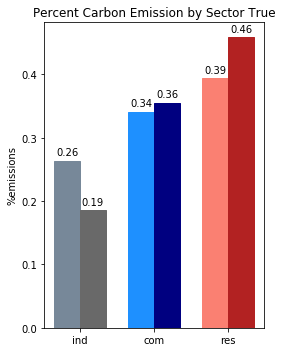

In [167]:
by='median_t'
labels=['ind','com','res']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
data1=ghg_by_class_and_split_type(1,by)
data2=ghg_by_class_and_split_type(2,by)

fig.set_size_inches(4, 5)

barlista=ax.bar(x - width/2,data1['%Carbon Emission'],width)
barlistb=ax.bar(x + width/2,data2['%Carbon Emission'],width)

# plt.plot(fig)
barlista[0].set_color('lightslategray')
barlista[1].set_color('dodgerblue')
barlista[2].set_color('salmon')
barlistb[0].set_color('dimgray')
barlistb[1].set_color('navy')
barlistb[2].set_color('firebrick')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
ax.set_ylabel('%emissions')
ax.set_title('Percent Carbon Emission by Sector True')
ax.set_xticks(x)
ax.set_xticklabels(labels)
# ax.legend()

autolabel(barlista)
autolabel(barlistb)

fig.tight_layout()

plt.show()

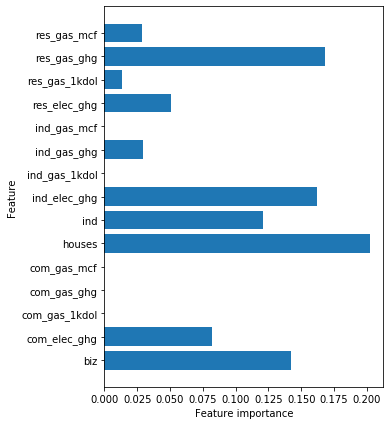

In [184]:
# X_train, X_test, y_train, y_test
def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.figure(figsize=(5,7))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

dt_clf.fit(X_train,y_train)
plot_feature_importances(dt_clf)